# Example illustrating how Bayesian evidence helps to evaluate detection significance of a given species

In [20]:
# import area
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from pyhapke import rad_tran
from pyhapke import op_cons
from pyhapke import utils
#from frostie import retrieval
#from utils import bin_to_mise
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyutils
from multiprocessing import Pool
from scipy.special import lambertw as W
from scipy.special import erfcinv
import warnings
from time import time
from scipy.signal import find_peaks, argrelextrema
import spectres
from matplotlib.colors import LogNorm
import matplotlib as mpl
import os
mpl.rcParams['figure.dpi'] = 100

In [21]:
# Temporarily defining Z_to_sigma function here

def Z_to_sigma(ln_Z1, ln_Z2):
    """Convert log-evidences of two models to a sigma confidence level
    
    Prameters
    ---------
    ln_Z1: float
        log of Bayesian evidence of model 1
    ln_Z2: float
        log of Bayesian evidence of model 2
        
    Returns
    -------
    
    B: float
        Bayes factor of model 1 to model 2
    sigma: float
        sigma evidence of model 1 over model 2
    """
    np.set_printoptions(precision=50)
    B = np.exp(ln_Z1 - ln_Z2)
    if B < 1.0:
        warnings.warn('Bayes factor is less than 1; sigma-significance is invalid')
    p = np.real(np.exp(W((-1.0/(B*np.exp(1))),-1)))
    sigma = np.sqrt(2)*erfcinv(p)
    #print "p-value = ", p
    #print "n_sigma = ", sigma
    return B, sigma

## Consider a simulated dataset of a mixture of olivine, anorthite and enstatite

In [35]:
# Define optical constants and fixed model parameters

# Read optical constants

filename = os.path.abspath(os.path.join('data','anorthite.txt'))
f=open(filename, 'r')
lines = f.read().splitlines()
lines = [lines[i].split() for i in range(len(lines))]
f.close()

wav_an = []
n_an = []
k_an = []

for i in range(len(lines)):
    wav_an.append(float(lines[i][0])*10**6)
    n_an.append(float(lines[i][1]))
    k_an.append(float(lines[i][2]))
    
wav_an = np.array(wav_an)
n_an = np.array(n_an)
k_an = np.array(k_an)

filename = os.path.abspath(os.path.join('data','olivine.txt'))
f=open(filename, 'r')
lines = f.read().splitlines()
lines = [lines[i].split() for i in range(len(lines))]
f.close()

wav_ol = []
n_ol = []
k_ol = []

for i in range(len(lines)):
    wav_ol.append(float(lines[i][0])*10**6)
    n_ol.append(float(lines[i][1]))
    k_ol.append(float(lines[i][2]))
    
wav_ol = np.array(wav_ol)
n_ol = np.array(n_ol)
k_ol = np.array(k_ol)

filename = os.path.abspath(os.path.join('data','enstatite.txt'))
f=open(filename, 'r')
lines = f.read().splitlines()
lines = [lines[i].split() for i in range(len(lines))]
f.close()

wav_en = []
n_en = []
k_en = []

for i in range(len(lines)):
    wav_en.append(float(lines[i][0])*10**6)
    n_en.append(float(lines[i][1]))
    k_en.append(float(lines[i][2]))
    
wav_en = np.array(wav_en)
n_en = np.array(n_en)
k_en = np.array(k_en)

# match the wavelength axes of the optical constants

wav_list = [wav_ol, wav_an, wav_en]
k_list = [k_ol, k_an, k_en]
n_list = [n_ol, n_an, n_en]

k_list, wav_common = utils.spectra_list_match(k_list,wav_list)
n_list, junk = utils.spectra_list_match(n_list,wav_list)


n_ol, k_ol, wav_ol = n_list[0], k_list[0], wav_common
n_an, k_an, wav_an = n_list[1], k_list[1], wav_common
n_en, k_en, wav_en = n_list[2], k_list[2], wav_common

# Define the fixed model parameters

mu_0 = np.cos(np.deg2rad(30))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(0))   # cosine of the emergence angle
g = 30    # phase angle 
B = 0     # No backscattering
s = 0    # internal scattering coefficient is zero
K = 1.0     # porosity coeffecient

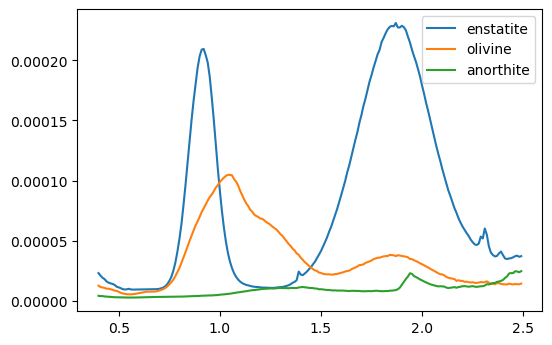

In [28]:
# plot the k spectra

plt.figure()
plt.plot(wav_en,k_en, label='enstatite')
plt.plot(wav_ol,k_ol, label='olivine')
plt.plot(wav_an,k_an, label='anorthite')
plt.legend()

In [36]:
# simualte data

log10D_ol, log10D_an, log10D_en = 2.0, 2.0, 2.0
f_ol, f_en, f_an = 0.33,0.33,0.34

ol_dict = {'n':n_ol,'k':k_ol,'wav':wav_ol,'log10D':log10D_ol, 'f':f_ol,'p_type':'isotropic'}
an_dict = {'n':n_an,'k':k_an,'wav':wav_an,'log10D':log10D_an, 'f':f_an,'p_type':'isotropic'}
en_dict = {'n':n_en,'k':k_en,'wav':wav_en,'log10D':log10D_en, 'f':f_en,'p_type':'isotropic'}

param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp_dict_list':[ol_dict, an_dict, en_dict]}

model_true, wav_model_true = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

# add Gaussian noise equivalent to SNR of 50

snr = 50
noise = model_true/snr
np.random.seed(42)
data = model_true + noise*np.random.randn(model_true.size)
wav_data = np.copy(wav_model_true)

In [37]:
# evaluate single component spectra to compare with the multi-component spectrum

ol_dict = {'n':n_ol,'k':k_ol,'wav':wav_ol,'log10D':log10D_ol, 'p_type':'isotropic'}
param_dict_ol = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp':ol_dict}
spec_ol, _ = rad_tran.one_comp(param_dict_ol, constant_D=True)

en_dict = {'n':n_en,'k':k_en,'wav':wav_en,'log10D':log10D_en, 'p_type':'isotropic'}
param_dict_en = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp':en_dict}
spec_en, _ = rad_tran.one_comp(param_dict_en, constant_D=True)

an_dict = {'n':n_an,'k':k_an,'wav':wav_an,'log10D':log10D_an, 'p_type':'isotropic'}
param_dict_an = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp':an_dict}
spec_an, _ = rad_tran.one_comp(param_dict_an, constant_D=True)

Text(0.5, 0, 'wavelength in microns')

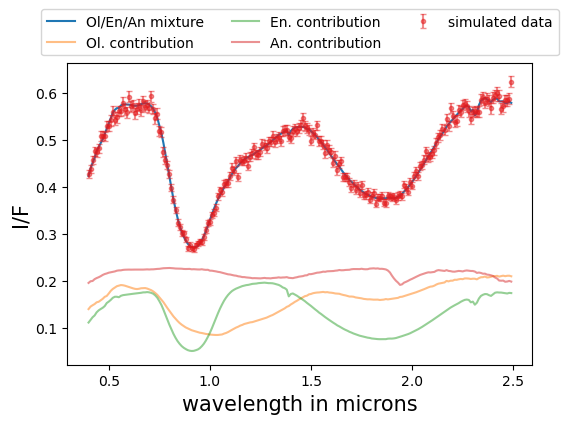

In [49]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(wav_model_true, model_true, label='Ol/En/An mixture')
ax.plot(wav_ol, f_ol*spec_ol, label='Ol. contribution', alpha=0.5)
ax.plot(wav_en, f_en*spec_en, label='En. contribution', alpha=0.5)
ax.plot(wav_an, f_an*spec_an, label='An. contribution', alpha=0.5)
ax.errorbar(wav_data, data, yerr=noise,color='#e41a1c',ls='none', marker='o', alpha=0.5, markersize=3, capsize=2, zorder=2, label='simulated data')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=10)
ax.set_ylabel('I/F', size=15)
ax.set_xlabel('wavelength in microns', size=15)

## Run a three component retrieval analysis

In [11]:
# Perform Bayesian retrieval using a two component model of amorphous water ice and hcn

# set bounds for priors on free-parameters: log10f_ol, log10f_en, log10D_ol, log10D_en, log10D_an

n_species=3
bounds = [(-3,0), (-3,0), (1.0,3.0),(1.0,3.0),(1.0,3.0)]

# fixed parameters

mu_0 = np.cos(np.deg2rad(30))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(0))   # cosine of the emergence angle
g = 30    # phase angle 
B = 0     # No backscattering
s = 0    # internal scattering coefficient is zero
K = 1.0     # porosity coeffecient

# check that noise is an array (to evaluate norm_log correctly)

if not(isinstance(noise, np.ndarray)):
    raise TypeError('noise variable should be a numpy array') 
        
norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise)**2))

def Dirichlet_Prior(params, lower_bound, n_species):
    
    ''' Impliments a Dirchlet prior for chemical mixing ratios.
    
        Dir[i] here is the centred log-ratio transform of the mixing ratio, X[i]
       
    '''
    
    n = n_species   # Number of species free parameters
    limit = lower_bound           # Lowest (log) mixing ratio considered

    # Limits correspond to condition that all X_i > 10^(limit)
    prior_lower_Dir = ((n-1.0)/n) * (limit * np.log(10.0) + np.log(n-1.0))      # Lower limit corresponds to species underabundant
    prior_upper_Dir = ((1.0-n)/n) * (limit * np.log(10.0))                      # Upper limit corresponds to species dominant

    Dir = np.zeros(shape=(n))   # Vector of log ratio parameters
    X = np.zeros(shape=(n))     # Vector of mixing ratio parameters
    
    # Evalaute centred log-ratio parameters by uniformly sampling between limits
    for i in range(n-1):
 
        Dir[1+i] = ((params[i] * (prior_upper_Dir - prior_lower_Dir)) + prior_lower_Dir) 
          
    if (np.abs(np.sum(Dir[1:n])) <= prior_upper_Dir):   # Impose same prior on X_0
    #if 1==1:
            
        Dir[0] = -1.0*np.sum(Dir[1:n])   # Dir_n (corresponding to mixing ratio of first species) must equal 0, so that X_i sum to 1
        
        if ((np.max(Dir) - np.min(Dir)) <= (-1.0 * limit * np.log(10.0))):      # Necessary for all X_i > 10^(limit)    
        #if 1==1:
            
            normalisation = np.sum(np.exp(Dir))
        
            for i in range(n):
                
                # Map log-ratio parameters to mixing ratios
                X[i] = np.exp(Dir[i]) / normalisation   # Vector of mixing ratios (should sum to 1!)
                
                # One final check that all X_i > 10^(limit)
                if (X[i] < 10**limit): 
                    #print('1')
                    return (np.ones(n)*(-np.inf))# Fails check -> return dummy array of log values
            
            return np.log10(X)   # Return vector of log-mixing ratios
        
        elif ((np.max(Dir) - np.min(Dir)) > (-1.0 * limit * np.log(10.0))):
            
            #print('2')
            return (np.ones(n)*(-np.inf))   # Fails check -> return dummy array of log values
    
    elif (np.abs(np.sum(Dir[1:n])) > prior_upper_Dir):   # If falls outside of allowed triangular subspace
        
        #print('3')
        return (np.ones(n)*(-np.inf))    # Fails check -> return dummy array of log values
    
def prior_trans_2comp(theta,prior_bounds=bounds, n_species=n_species):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)
    
    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler; assumes abundances are indexed first
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.
        
    Returns
    -------
    
    tuple containing all the transformed free parameter values
    """
    # first get the abundance values
    
    lower_bound = bounds[0][0]    # assuming all species have same lower bound on prior
    
    transformed = Dirichlet_Prior(theta[:n_species-1], lower_bound=lower_bound, n_species=n_species)
    
    # get other parameter values
    
    for i in range(n_species-1,len(theta)):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]
        
        param = theta[i]*(param_max - param_min) + param_min
        
        transformed = np.append(transformed,param)
        
    return transformed


def loglik_2comp(theta):
    """
    The log-likelihood function.
    """
    if np.all(theta[:n_species] != np.ones(n_species)*(-np.inf)):
        
        log10f_an, log10f_ol, log10f_en, log10D_ol, log10D_en, log10D_an = theta[0], theta[1], theta[2], theta[3], theta[4], theta[5] # unpack the parameters

        # the fixed parameters are global and have been defined earlier in the notebook

        # Create synthetic data

        ol_dict = {'n':n_ol,'k':k_ol,'wav':wav_ol,'log10D':log10D_ol, 'f':10**log10f_ol,'p_type':'isotropic'}
        an_dict = {'n':n_an,'k':k_an,'wav':wav_an,'log10D':log10D_an, 'f':10**log10f_an,'p_type':'isotropic'}
        en_dict = {'n':n_en,'k':k_en,'wav':wav_en,'log10D':log10D_en, 'f':10**log10f_en,'p_type':'isotropic'}

        param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp_dict_list':[ol_dict, an_dict, en_dict]}

        model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=True)

        chisq = -0.5*np.sum((model-data)**2/(noise)**2)

        return chisq + norm_log
    
    else:
        return -np.inf

In [13]:
# Run retrieval

# prior_trans and loglik are defined above

nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 5        # number of free parameters
sample = 'unif'  # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler_all = NestedSampler(loglik_2comp, prior_trans_2comp, ndims,
                        bound=bound, sample=sample, nlive=nlive, pool=pool, queue_size=Nproc)

sampler_all.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 10508 | +512 | bound: 58 | nc: 1 | ncall: 62247 | eff(%): 17.704 | loglstar:   -inf < 696.657 <    inf | logz: 678.476 +/-    nan | dlogz:  0.000 >  0.100                                      Process ForkPoolWorker-24:
Process ForkPoolWorker-36:
Process ForkPoolWorker-38:
Process ForkPoolWorker-29:
Process ForkPoolWorker-33:
Process ForkPoolWorker-32:
Process ForkPoolWorker-26:
Process ForkPoolWorker-40:
Process ForkPoolWorker-23:
Process ForkPoolWorker-21:
Process ForkPoolWorker-39:
Process ForkPoolWorker-30:
Process ForkPoolWorker-28:
Process ForkPoolWorker-37:
Process ForkPoolWorker-35:
Process ForkPoolWorker-34:
Process ForkPoolWorker-31:
Process ForkPoolWorker-22:
Process ForkPoolWorker-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-27:
Traceback (most recent call last):
Traceback (most r

Process ForkPoolWorker-2:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-15:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-10:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-20:
Process ForkPoolWorker-18:
Process ForkPoolWorker-16:
Process ForkPoolWorker-14:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

In [ ]:
# print ML parameters

samples = sampler_all.results
idx = np.where(samples['logl'] == samples['logl'].max())[0]
samples['samples'][idx][0]

### Retrieval without olivine

In [14]:
# Perform Bayesian retrieval using a two component model of amorphous water ice and hcn

# set bounds for priors on free-parameters: log10f_en, log10D_en, log10D_an

bounds = [(-3,0), (1.0,3.0),(1.0,3.0)]

# fixed parameters

mu_0 = np.cos(np.deg2rad(30))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(0))   # cosine of the emergence angle
g = 30    # phase angle 
B = 0     # No backscattering
s = 0    # internal scattering coefficient is zero
K = 1.0     # porosity coeffecient

# check that noise is an array (to evaluate norm_log correctly)

if not(isinstance(noise, np.ndarray)):
    raise TypeError('noise variable should be a numpy array') 
        
norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise)**2))

def prior_trans(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)

    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.

    Returns
    -------

    tuple containing all the transformed free parameter values
    """

    transformed = ()

    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]

        param = param_prime*(param_max - param_min) + param_min

        transformed += (param,)

    return transformed

def loglik(theta):
    """
    The log-likelihood function.
    """

    log10f_en, log10D_en, log10D_an = theta # unpack the parameters
    
    f_en = 10**log10f_en
    f_an =  1 - f_en
    
    # the fixed parameters are global and have been defined earlier in the notebook

    en_dict = {'n':n_en,'k':k_en,'wav':wav_en,'log10D':log10D_en, 'f':f_en,'p_type':'isotropic'}
    an_dict = {'n':n_an,'k':k_an,'wav':wav_an,'log10D':log10D_an, 'f':f_an,'p_type':'isotropic'}

    param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,
                    'comp_dict_list':[en_dict, an_dict]}

    model, _ = rad_tran.multi_comp_IM(param_dict, matched_axes=True)
    
    chisq = -0.5*np.sum((model-data)**2/(noise)**2)

    return chisq + norm_log

In [16]:
# Run retrieval

# prior_trans and loglik are defined above

nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3        # number of free parameters
sample = 'unif'  # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler_all = NestedSampler(loglik, prior_trans, ndims,
                        bound=bound, sample=sample, nlive=nlive, pool=pool, queue_size=Nproc)

sampler_all.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 14018 | +512 | bound: 46 | nc: 1 | ncall: 52933 | eff(%): 27.450 | loglstar:   -inf < -1757.216 <    inf | logz: -1782.258 +/-  0.297 | dlogz:  0.000 >  0.100                                  Process ForkPoolWorker-135:
Process ForkPoolWorker-139:
Process ForkPoolWorker-137:
Process ForkPoolWorker-133:
Process ForkPoolWorker-132:
Process ForkPoolWorker-122:
Process ForkPoolWorker-130:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-129:
Process ForkPoolWorker-125:
Process ForkPoolWorker-140:
Process ForkPoolWorker-123:
Process ForkPoolWorker-136:
  File "/data1/ishanm/.conda/envs/europa_research/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data1/ishanm/.conda/envs/europa_research/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-124:
Traceback (most recent call last):
Process ForkPoolWorker-134:
Traceback (most recent call last):
Traceb

In [22]:
# Evidence for Olivine

logZ_all = 678.476
logZ_without = -1782.258

from IPython.display import display,Math

B, sigma = Z_to_sigma(logZ_all,logZ_without)

display(Math(r'\rm Log \ Bayes \ factor \ of \ reference \ model \ to \  current \ model = {}'.format(logZ_all - logZ_without)))

display(Math(r'\rm Evidence \ for \ Olivine: {0:0.3f} \ \sigma'.format(sigma)))

/tmp/ipykernel_18137/318819947.py:22: RuntimeWarning: overflow encountered in exp
  B = np.exp(ln_Z1 - ln_Z2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Retrieval without enstatite

In [24]:
# Perform Bayesian retrieval using a two component model of amorphous water ice and hcn

# set bounds for priors on free-parameters: log10f_ol, log10D_ol, log10D_an

bounds = [(-3,0), (1.0,3.0),(1.0,3.0)]

# fixed parameters

mu_0 = np.cos(np.deg2rad(30))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(0))   # cosine of the emergence angle
g = 30    # phase angle 
B = 0     # No backscattering
s = 0    # internal scattering coefficient is zero
K = 1.0     # porosity coeffecient

# check that noise is an array (to evaluate norm_log correctly)

if not(isinstance(noise, np.ndarray)):
    raise TypeError('noise variable should be a numpy array') 
        
norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise)**2))

def prior_trans(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)

    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.

    Returns
    -------

    tuple containing all the transformed free parameter values
    """

    transformed = ()

    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]

        param = param_prime*(param_max - param_min) + param_min

        transformed += (param,)

    return transformed

def loglik(theta):
    """
    The log-likelihood function.
    """

    log10f_ol, log10D_ol, log10D_an = theta # unpack the parameters
    
    f_ol = 10**log10f_ol
    f_an =  1 - f_ol
    
    # the fixed parameters are global and have been defined earlier in the notebook

    en_dict = {'n':n_ol,'k':k_ol,'wav':wav_ol,'log10D':log10D_ol, 'f':f_ol,'p_type':'isotropic'}
    an_dict = {'n':n_an,'k':k_an,'wav':wav_an,'log10D':log10D_an, 'f':f_an,'p_type':'isotropic'}

    param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,
                    'comp_dict_list':[en_dict, an_dict]}

    model, _ = rad_tran.multi_comp_IM(param_dict, matched_axes=True)
    
    chisq = -0.5*np.sum((model-data)**2/(noise)**2)

    return chisq + norm_log

In [25]:
# Run retrieval

# prior_trans and loglik are defined above

nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3        # number of free parameters
sample = 'unif'  # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler_all = NestedSampler(loglik, prior_trans, ndims,
                        bound=bound, sample=sample, nlive=nlive, pool=pool, queue_size=Nproc)

sampler_all.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 10440 | +512 | bound: 35 | nc: 1 | ncall: 44497 | eff(%): 24.613 | loglstar:   -inf < -4620.333 <    inf | logz: -4638.375 +/-  0.253 | dlogz:  0.000 >  0.100                                  Process ForkPoolWorker-144:
Process ForkPoolWorker-141:
Process ForkPoolWorker-153:
Process ForkPoolWorker-157:
Process ForkPoolWorker-156:
Process ForkPoolWorker-152:
Process ForkPoolWorker-149:
Process ForkPoolWorker-159:
Process ForkPoolWorker-142:
Process ForkPoolWorker-151:
Process ForkPoolWorker-148:
Traceback (most recent call last):
Process ForkPoolWorker-150:
Process ForkPoolWorker-158:
  File "/data1/ishanm/.conda/envs/europa_research/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data1/ishanm/.conda/envs/europa_research/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-154:
Process ForkPoolWorker-147:
Traceback (most recent call last):
Traceback (most recent c

In [26]:
# Evidence for Enstatite

logZ_all = 678.476
logZ_without = -4638.375

from IPython.display import display,Math

B, sigma = Z_to_sigma(logZ_all,logZ_without)

display(Math(r'\rm Log \ Bayes \ factor \ of \ reference \ model \ to \  current \ model = {}'.format(logZ_all - logZ_without)))

display(Math(r'\rm Evidence \ for \ Enstatite: {0:0.3f} \ \sigma'.format(sigma)))

/tmp/ipykernel_18137/318819947.py:22: RuntimeWarning: overflow encountered in exp
  B = np.exp(ln_Z1 - ln_Z2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Retrieval without anorthite

In [31]:
# Perform Bayesian retrieval using a two component model of amorphous water ice and hcn

# set bounds for priors on free-parameters: log10f_ol, log10D_ol, log10D_en

bounds = [(-3,0), (1.0,3.0),(1.0,3.0)]

# fixed parameters

mu_0 = np.cos(np.deg2rad(30))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(0))   # cosine of the emergence angle
g = 30    # phase angle 
B = 0     # No backscattering
s = 0    # internal scattering coefficient is zero
K = 1.0     # porosity coeffecient

# check that noise is an array (to evaluate norm_log correctly)

if not(isinstance(noise, np.ndarray)):
    raise TypeError('noise variable should be a numpy array') 
        
norm_log = -0.5*np.sum(np.log(2.0*np.pi*(noise)**2))

def prior_trans(theta,prior_bounds=bounds):
    """ A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters. Used in dynesty (nested sampling)

    Parameters
    ----------
    theta: tuple of floats
        free parameter values supplied by the sampler
    prior_bounds: list of tuples
        each tuple contains the lower and upper bound for the corresponding free parameter in free_params. This
        assumes that the parameters are uniformly distributed.

    Returns
    -------

    tuple containing all the transformed free parameter values
    """

    transformed = ()

    for i,param_prime in enumerate(theta):
        param_min = prior_bounds[i][0]
        param_max = prior_bounds[i][1]

        param = param_prime*(param_max - param_min) + param_min

        transformed += (param,)

    return transformed

def loglik(theta):
    """
    The log-likelihood function.
    """

    log10f_ol, log10D_ol, log10D_en = theta # unpack the parameters
    
    f_ol = 10**log10f_ol
    f_en =  1 - f_ol
    
    # the fixed parameters are global and have been defined earlier in the notebook

    ol_dict = {'n':n_ol,'k':k_ol,'wav':wav_ol,'log10D':log10D_ol, 'f':f_ol,'p_type':'isotropic'}
    en_dict = {'n':n_en,'k':k_en,'wav':wav_en,'log10D':log10D_en, 'f':f_en,'p_type':'isotropic'}

    param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,
                    'comp_dict_list':[ol_dict, en_dict]}

    model, _ = rad_tran.multi_comp_IM(param_dict, matched_axes=True)
    
    chisq = -0.5*np.sum((model-data)**2/(noise)**2)

    return chisq + norm_log

In [32]:
# Run retrieval

# prior_trans and loglik are defined above

nlive = 512      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3        # number of free parameters
sample = 'unif'  # uniform sampling
tol = 0.1         # the stopping criterion

Nproc = 20
pool = Pool(processes=Nproc)

sampler_all = NestedSampler(loglik, prior_trans, ndims,
                        bound=bound, sample=sample, nlive=nlive, pool=pool, queue_size=Nproc)

sampler_all.run_nested(dlogz=tol, print_progress=True) # output progress bar

iter: 12617 | +512 | bound: 43 | nc: 1 | ncall: 51243 | eff(%): 25.621 | loglstar:   -inf < 641.183 <    inf | logz: 618.893 +/-  0.283 | dlogz:  0.000 >  0.100                                      Process ForkPoolWorker-241:
Process ForkPoolWorker-259:
Process ForkPoolWorker-250:
Process ForkPoolWorker-245:
Process ForkPoolWorker-242:
Process ForkPoolWorker-255:
Process ForkPoolWorker-248:
Process ForkPoolWorker-257:
Process ForkPoolWorker-246:
Process ForkPoolWorker-256:
Process ForkPoolWorker-251:
Process ForkPoolWorker-254:
Process ForkPoolWorker-253:
Process ForkPoolWorker-247:
Process ForkPoolWorker-252:
Process ForkPoolWorker-249:
Process ForkPoolWorker-260:
Process ForkPoolWorker-258:


In [33]:
# Evidence for Anorthite

logZ_all = 678.476
logZ_without = 618.893

from IPython.display import display,Math

B, sigma = Z_to_sigma(logZ_all,logZ_without)

display(Math(r'\rm Log \ Bayes \ factor \ of \ reference \ model \ to \  current \ model = {}'.format(logZ_all - logZ_without)))

display(Math(r'\rm Evidence \ for \ Anorthite: {0:0.3f} \ \sigma'.format(sigma)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [34]:
# print ML parameters

samples = sampler_all.results
idx = np.where(samples['logl'] == samples['logl'].max())[0]
samples['samples'][idx][0]

array([-0.0032505705600414103,  1.6179933207734254   ,
        2.355707669629981    ])